In [1]:
'''
author: Felix Hol
date: 2019 June 24
content: find curve around mosquito body using active contour (snakelet), find max width of short axis and determine engorgement
'''

import numpy as np
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') ### this is a workaround for a bug when running on macOS, may not be necessary anymore
import matplotlib.pyplot as plt
import os
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import skimage
from skimage import data, io, util
from skimage.feature import (canny, match_descriptors, peak_local_max, match_template, corner_peaks, corner_harris, plot_matches, BRIEF)
from skimage.color import rgb2gray
from skimage.draw import circle
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, erosion, dilation, opening, binary_closing, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
from scipy import ndimage as ndi
import scipy
import trackpy as tp
import pylab
import math
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime
from tqdm import tnrange
import pickle
from PIL import Image
from tqdm import tnrange
import glob
import cv2 as cv

In [2]:
dataDir = '/Volumes/Fe_ssd02/biteData/190618_KPPTN/190618_KPPTN_crops200-9000/'
saveDir = '/Volumes/Fe_ssd02/biteData/190618_KPPTN/190618_KPPTN_analysis/'
frames = pims.ImageSequence(dataDir+'/*p074*.png', as_grey=True)

In [3]:
frameSize = frames[0].shape
BG = np.zeros([frameSize[0], frameSize[1]])
BG[:][:] = 10

In [4]:
#### get centroid

def trackMosq2(i):
    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 70
    Bts = remove_small_objects(Bt, min_size=300)
    Be = erosion(Bts, selem2)
    Bf = remove_small_objects(Be, min_size=200)
    Bc = binary_closing(Bf, selem1)
    C = B * Bc
    eroded = erosion(C, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    eroded[eroded < 0] = 0
    erL = label(eroded>0)
    erR = regionprops(erL, C)#, coordinates='xy')
    l = 1
    for props in erR:
        if props.area > 100000:
            erL[erL==l] = 0
        if props.major_axis_length > 1000:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf, C)#, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        numCent += 1
#     coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
#     cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
#     frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
#     frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
#     coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
#     coordinatesF = np.hstack((coordinates,frameNoA))
#     numCoords = coordinatesF.shape[0]
    numCents = centroidsF.shape[0]
    return centroidsF, numCents


In [5]:
bellySizeRR = np.empty([0, 0])

### parameters for p074

for i in tnrange(5, 600, 8):
#     print(i)
    centroidsF, numCents = trackMosq2(i)
    s = np.linspace(0, 2*np.pi, 400)
    x = centroidsF[0,1] + 120*np.cos(s)
    y = centroidsF[0,0] + 120*np.sin(s)
    init = np.array([x, y]).T
    imBTH = skimage.morphology.black_tophat(frames[i], disk(3))
    imBT = imBTH > 15
    F = frames[i]
    F[imBT] = np.median(F)
    F = skimage.filters.gaussian(F, 5)
    snake = skimage.segmentation.active_contour(F*10, init, alpha=0.015, beta=80, gamma=0.001, w_edge=2)
    snakeD = np.expand_dims(snake, axis=1)
    rotRect = cv.minAreaRect(snakeD.astype(int))
    bellySizeRR = np.append(bellySizeRR, rotRect[1][1])

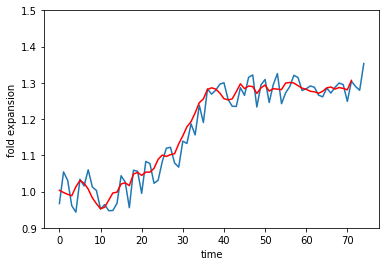

In [10]:
bellySizeC = bellySizeRR
bellySizeC[bellySizeC < 35] = np.nan
initSize = np.nanmean(bellySizeC[0:20])

plt.plot(bellySizeRR / initSize)
N = 4
bellySizeC = bellySizeRR
bellySizeC[bellySizeC < 35] = np.nan
bellySizeS = np.convolve(bellySizeC, np.ones((N,))/N, mode='valid')
plt.plot(bellySizeS / initSize, 'r')
plt.ylim([0.9, 1.5])
plt.xlabel('time')
plt.ylabel('fold expansion')